## 03 - Volatility Regime Analysis  
In this notebook we classify the market into volatility regimes and visualize where motifs occur relative to these regimes.

In [1]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.utils import data_path

### Load processed BTCUSDT log return data

In [3]:
processed_files = sorted(data_path("processed").glob("*.parquet"))
if not processed_files:
    raise FileNotFoundError("No processed parquet files found. Run notebook 01 first.")
df = pd.read_parquet(processed_files[0])

### Recreate motif indices from Notebook 02
If motif indices are not already stored, recompute them using the same window and Matrix Profile configuration.

In [4]:
import stumpy
series = df["log_return"].dropna().to_numpy(dtype=float)
m = 60
mp = stumpy.stump(series, m)
profile = mp[:, 0].astype(float)
motif_idx = int(np.argmin(profile))
neighbor_idx = int(mp[motif_idx, 1])

### Compute rolling realized volatility and classify regimes

In [5]:
df["rolling_vol_60"] = df["log_return"].rolling(m).std()

low_thresh  = df["rolling_vol_60"].quantile(0.33)
high_thresh = df["rolling_vol_60"].quantile(0.66)

def classify_regime(vol):
    if vol < low_thresh:
        return "Low Vol"
    elif vol > high_thresh:
        return "High Vol"
    else:
        return "Normal"

df["vol_regime"] = df["rolling_vol_60"].apply(classify_regime)

### Visualize volatility regimes on price

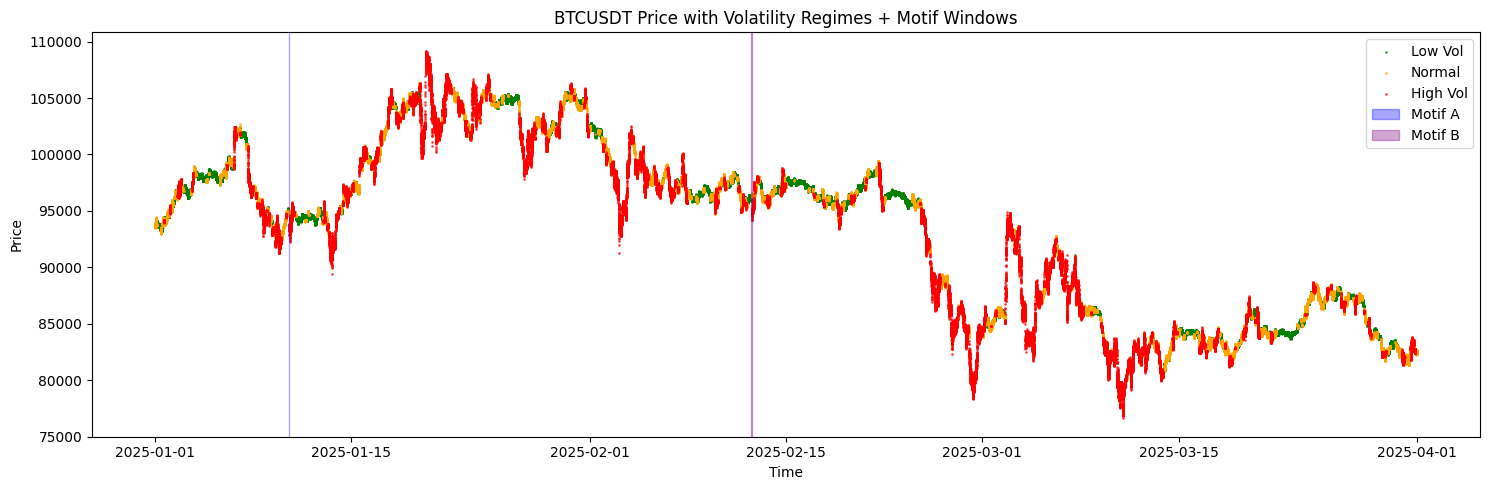

In [9]:
plt.figure(figsize=(15,5))

# Plot price with regime coloring
for regime, color in zip(
    ["Low Vol", "Normal", "High Vol"],
    ["green", "orange", "red"]
):
    subset = df[df["vol_regime"] == regime]
    plt.scatter(
        subset["open_time"],
        subset["close"],
        s=1,
        color=color,
        label=regime,
        alpha=0.6
    )

# Overlay motif windows
plt.axvspan(
    df.iloc[motif_idx]["open_time"],
    df.iloc[motif_idx + m]["open_time"],
    color="blue",
    alpha=0.35,
    label="Motif A"
)

plt.axvspan(
    df.iloc[neighbor_idx]["open_time"],
    df.iloc[neighbor_idx + m]["open_time"],
    color="purple",
    alpha=0.35,
    label="Motif B"
)

plt.title("BTCUSDT Price with Volatility Regimes + Motif Windows")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()


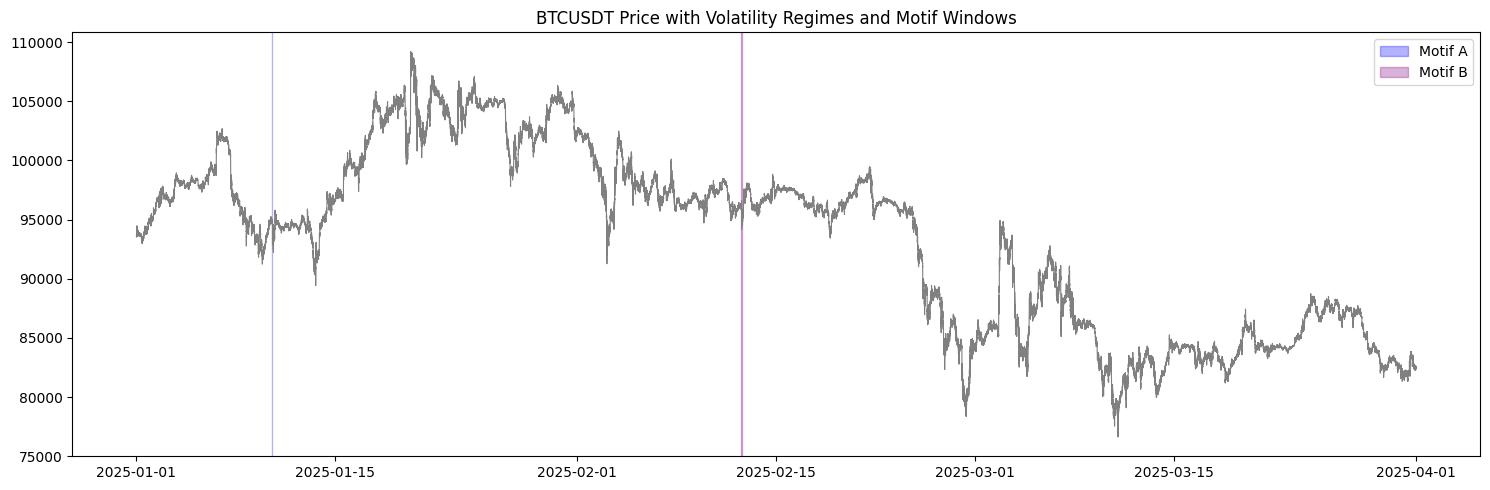

In [10]:
plt.figure(figsize=(15,5))

plt.plot(df["open_time"], df["close"], color="gray", linewidth=0.8)

# Overlay volatility regimes as background shading
for regime, color in zip(
    ["Low Vol", "Normal", "High Vol"],
    ["green", "orange", "red"]
):
    mask = df["vol_regime"] == regime
    plt.fill_between(
        df["open_time"],
        df["close"].min(),
        df["close"].max(),
        where=mask,
        color=color,
        alpha=0.05,
        transform=plt.gca().get_xaxis_transform()
    )

# Overlay motif windows
plt.axvspan(
    df.iloc[motif_idx]["open_time"],
    df.iloc[motif_idx + m]["open_time"],
    color="blue",
    alpha=0.3,
    label="Motif A"
)

plt.axvspan(
    df.iloc[neighbor_idx]["open_time"],
    df.iloc[neighbor_idx + m]["open_time"],
    color="purple",
    alpha=0.3,
    label="Motif B"
)

plt.title("BTCUSDT Price with Volatility Regimes and Motif Windows")
plt.legend()
plt.tight_layout()
plt.show()


### Display regime labels at motif timestamps

In [8]:
motif_time_a = df.iloc[motif_idx]["open_time"]
motif_time_b = df.iloc[neighbor_idx]["open_time"]
regime_a = df.iloc[motif_idx]["vol_regime"]
regime_b = df.iloc[neighbor_idx]["vol_regime"]

print(f"Motif A occurs at {motif_time_a} in regime: {regime_a}")
print(f"Motif B occurs at {motif_time_b} in regime: {regime_b}")

Motif A occurs at 2025-01-10 12:30:00+00:00 in regime: Normal
Motif B occurs at 2025-02-12 12:30:00+00:00 in regime: Low Vol


### STEP 1 — Helper Function for Zoom Windows

In [13]:
def plot_zoom_window(center_idx, window_minutes=360, title="Zoom View"):
    start = max(0, center_idx - window_minutes)
    end   = min(len(df)-1, center_idx + window_minutes)

    subset = df.iloc[start:end]

    plt.figure(figsize=(12,4))
    plt.plot(subset["open_time"], subset["close"], color="black", linewidth=1)

    # Highlight motif window if inside range
    if start <= motif_idx <= end:
        plt.axvspan(
            df.iloc[motif_idx]["open_time"],
            df.iloc[motif_idx + m]["open_time"],
            color="blue", alpha=0.3
        )

    if start <= neighbor_idx <= end:
        plt.axvspan(
            df.iloc[neighbor_idx]["open_time"],
            df.iloc[neighbor_idx + m]["open_time"],
            color="purple", alpha=0.3
        )

    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.tight_layout()
    plt.show()


### STEP 2 — Zoom Around Motif A

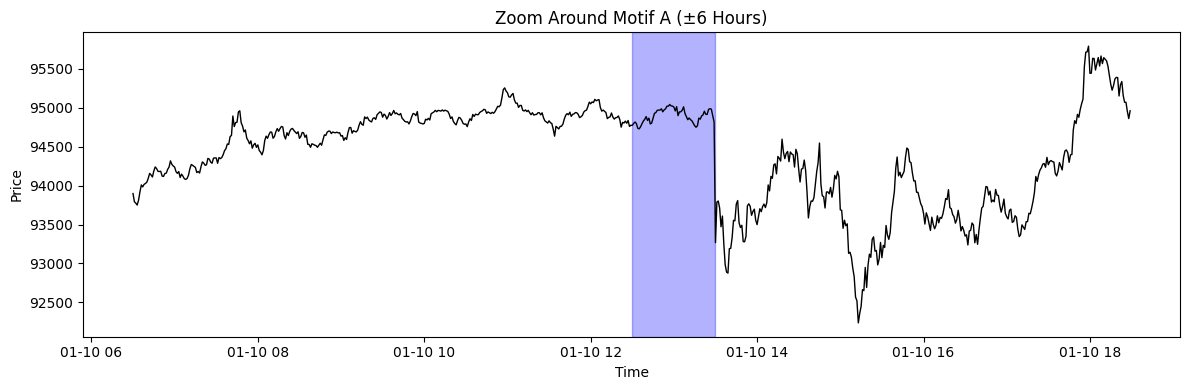

In [14]:
plot_zoom_window(
    motif_idx,
    window_minutes=360,
    title="Zoom Around Motif A (±6 Hours)"
)


### STEP 3 — Zoom Around Motif B

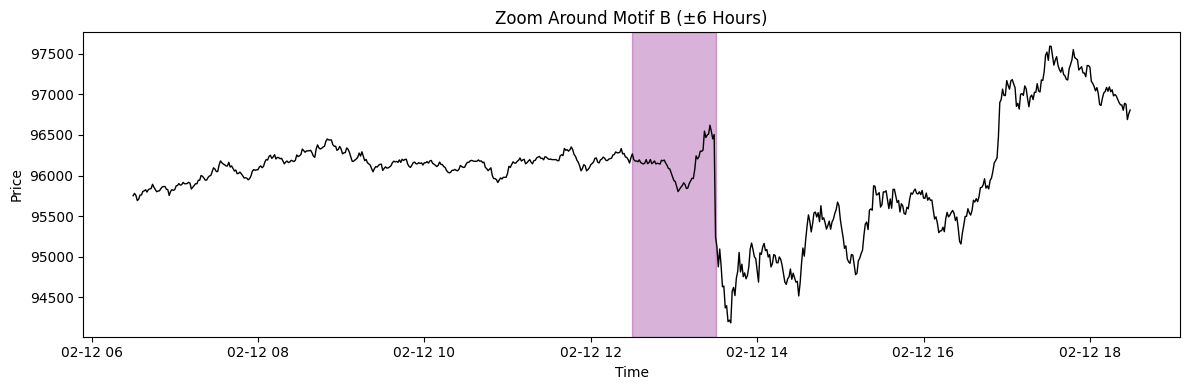

In [15]:
plot_zoom_window(
    neighbor_idx,
    window_minutes=360,
    title="Zoom Around Motif B (±6 Hours)"
)


### STEP 4 — Show Volatility Directly Under Price

In [17]:
def plot_zoom_with_vol(center_idx, window_minutes=360, title="Zoom with Volatility"):
    start = max(0, center_idx - window_minutes)
    end   = min(len(df)-1, center_idx + window_minutes)

    subset = df.iloc[start:end]

    fig, ax1 = plt.subplots(figsize=(12,4))

    ax1.plot(subset["open_time"], subset["close"], color="black", linewidth=1)
    ax1.set_ylabel("Price")

    ax2 = ax1.twinx()
    ax2.plot(subset["open_time"], subset["rolling_vol_60"], color="red", alpha=0.5)
    ax2.set_ylabel("Rolling Volatility")

    plt.title(title)
    plt.tight_layout()
    plt.show()


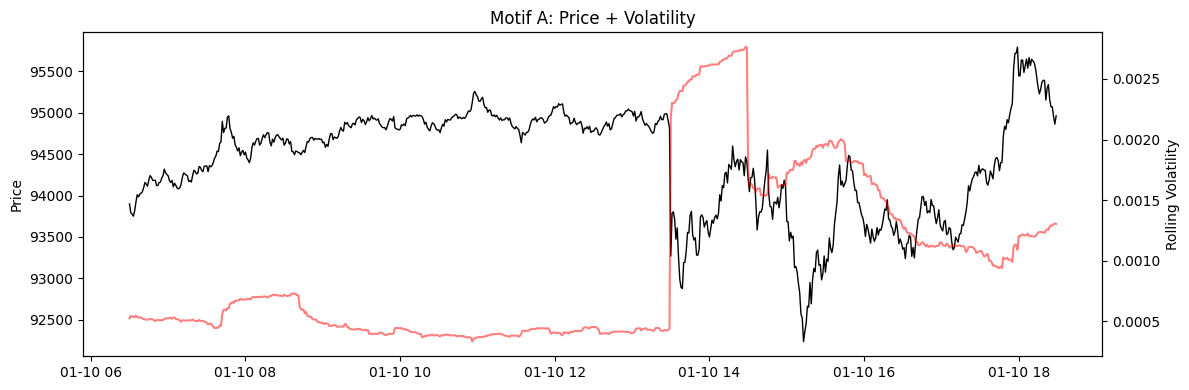

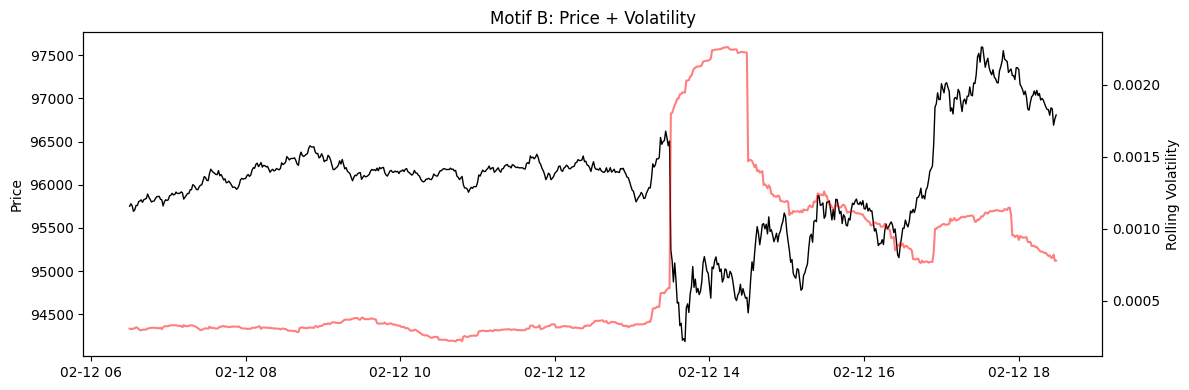

In [18]:
plot_zoom_with_vol(motif_idx, 360, "Motif A: Price + Volatility")
plot_zoom_with_vol(neighbor_idx, 360, "Motif B: Price + Volatility")


### STEP 5 — Show Pure Regime Example (Non-Motif)

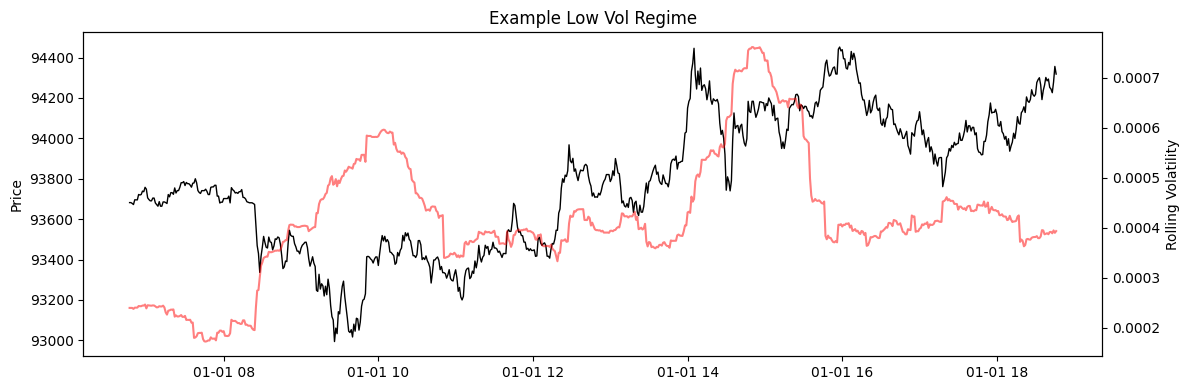

In [19]:
low_vol_idx = df[df["vol_regime"] == "Low Vol"].index[500]

plot_zoom_with_vol(low_vol_idx, 360, "Example Low Vol Regime")


👆🏻Black line → Price

Red line → Rolling 60-min Volatility

Title → “Example Low Vol Regime”

This is a zoomed ±6 hour window.

Bottom 33% → Low Vol

Middle 33% → Normal

Top 33% → High Vol

And visually show those thresholds on the volatility chart

In [ ]:
def plot_zoom_with_regime_bands(center_idx, window_minutes=360, title="Zoom with Regime Bands"):
    start = max(0, center_idx - window_minutes)
    end   = min(len(df)-1, center_idx + window_minutes)

    subset = df.iloc[start:end]

    fig, ax1 = plt.subplots(figsize=(12,4))

    # Price (left axis)
    ax1.plot(subset["open_time"], subset["close"], color="black", linewidth=1)
    ax1.set_ylabel("Price")

    # Volatility (right axis)
    ax2 = ax1.twinx()
    ax2.plot(subset["open_time"], subset["rolling_vol_60"], color="red", alpha=0.7)
    ax2.set_ylabel("Rolling Volatility")

    # ---- Add regime thresholds ----
    ax2.axhline(low_thresh, color="green", linestyle="--", linewidth=1)
    ax2.axhline(high_thresh, color="darkred", linestyle="--", linewidth=1)

    # ---- Shade volatility zones ----
    ax2.fill_between(
        subset["open_time"],
        0,
        low_thresh,
        color="green",
        alpha=0.05,
        label="Low Vol (Bottom 33%)"
    )

    ax2.fill_between(
        subset["open_time"],
        high_thresh,
        subset["rolling_vol_60"].max(),
        color="red",
        alpha=0.05,
        label="High Vol (Top 33%)"
    )

    ax2.text(
        subset["open_time"].iloc[5],
        low_thresh,
        "33% Quantile",
        color="green"
    )

    ax2.text(
        subset["open_time"].iloc[5],
        high_thresh,
        "66% Quantile",
        color="darkred"
    )

    plt.title(title)
    fig.tight_layout()
    plt.show()


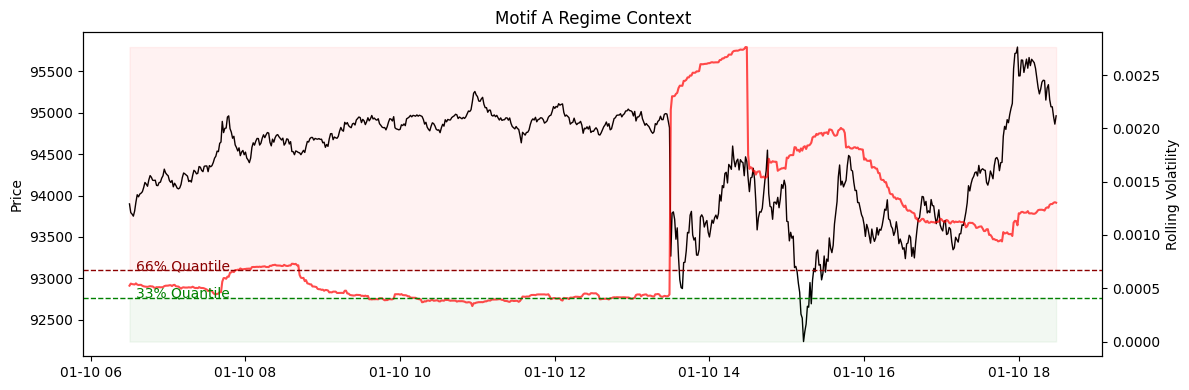

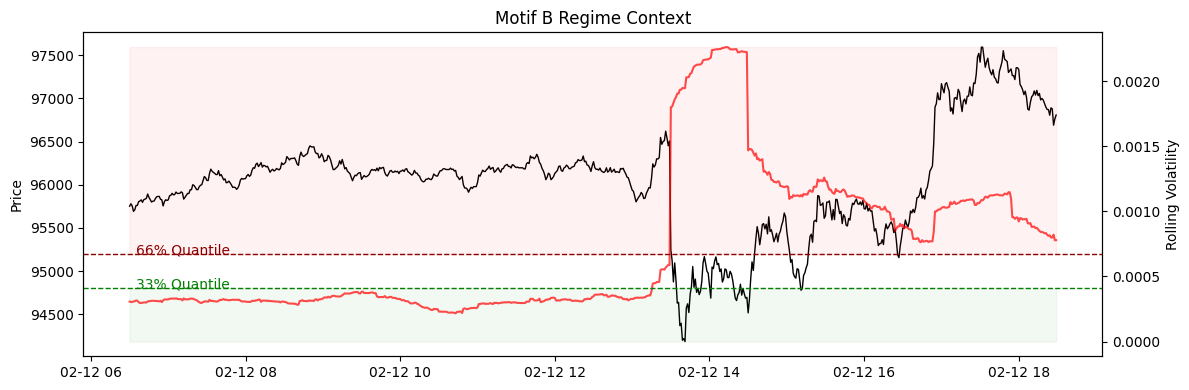

In [21]:
plot_zoom_with_regime_bands(motif_idx, 360, "Motif A Regime Context")
plot_zoom_with_regime_bands(neighbor_idx, 360, "Motif B Regime Context")


In [22]:
print("Low Vol Threshold (33%):", low_thresh)
print("High Vol Threshold (66%):", high_thresh)


Low Vol Threshold (33%): 0.0004106269621006598
High Vol Threshold (66%): 0.0006704769606803045


In [23]:
# ---- REQUIRED OBJECTS / COLUMNS CHECK ----

required_vars = [
    "df", "series", "m",
    "mp", "profile",
    "motif_idx", "neighbor_idx",
    "low_thresh", "high_thresh"
]

missing = [v for v in required_vars if v not in globals()]
if missing:
    raise NameError(f"Missing required variables: {missing}")

required_cols = ["open_time", "close", "log_return", "rolling_vol_60", "vol_regime"]
missing_cols = [c for c in required_cols if c not in df.columns]
if missing_cols:
    raise KeyError(f"Missing required df columns: {missing_cols}")

print("✅ All required variables and columns exist.")
print("Window length m =", m)
print("Rows in df =", len(df))


✅ All required variables and columns exist.
Window length m = 60
Rows in df = 129600



# 🔎 Technical Summary — Motif & Regime Analysis

## Dataset
- Observations: **129,600**
- Window length (m): **60 minutes**
- Signal used: **Log Returns**

## Matrix Profile
- Minimum motif distance: **2.7217**
- Motif A timestamp: **2025-01-10 12:30:00+00:00**
- Motif B timestamp: **2025-02-12 12:30:00+00:00**

## Volatility Regime Thresholds
- Low Vol (<33% quantile): **0.000411**
- High Vol (>66% quantile): **0.000670**

## Regime at Motif Occurrence
- Motif A regime: **Normal**
- Motif B regime: **Low Vol**

## Average Rolling Volatility Inside Motifs
- Motif A mean vol: **0.000423**
- Motif B mean vol: **0.000385**

## Overall Regime Distribution
- Low Vol: **32.98%**
- Normal: **33.03%**
- High Vol: **33.98%**


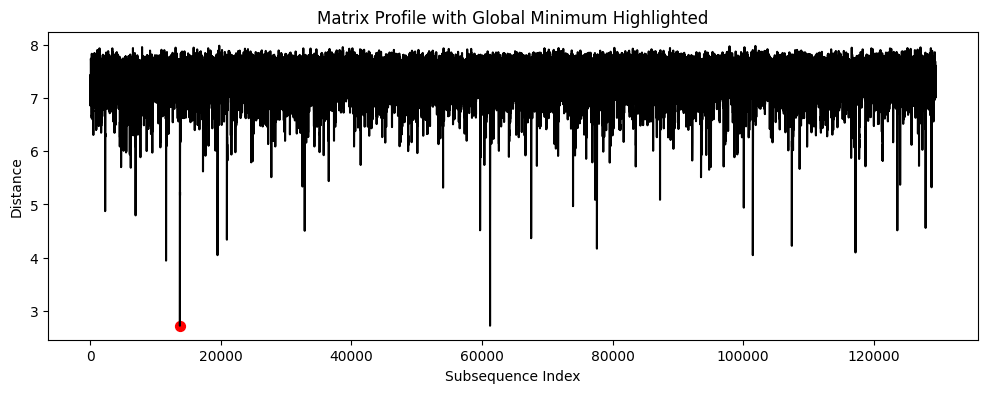

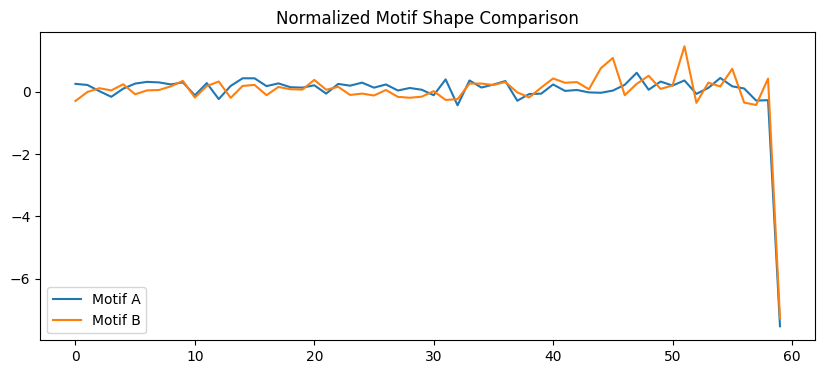

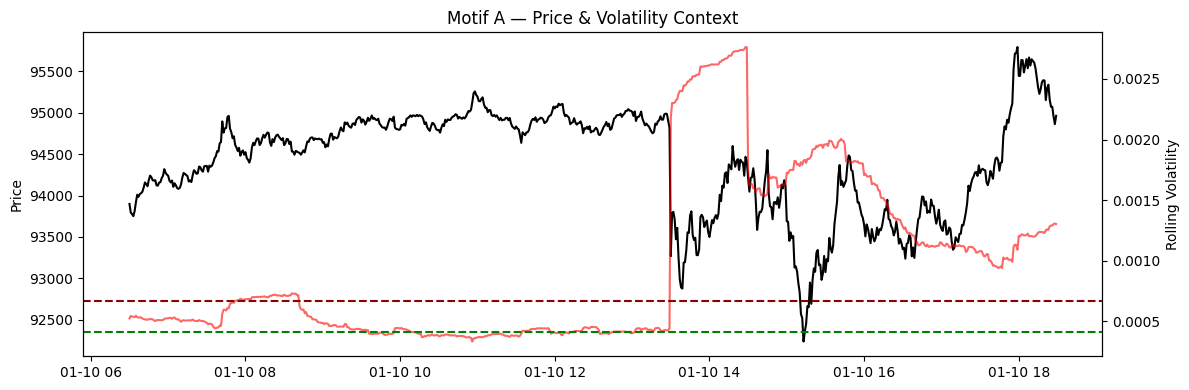

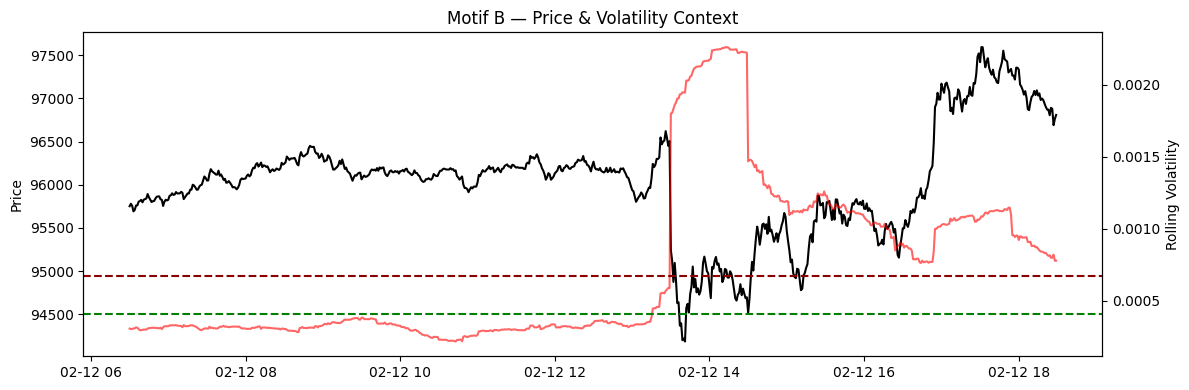

In [24]:
from IPython.display import Markdown, display
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1️⃣ Extract Core Metrics
# -----------------------------

motif_time_a = df.iloc[motif_idx]["open_time"]
motif_time_b = df.iloc[neighbor_idx]["open_time"]

motif_distance = profile[motif_idx]

regime_a = df.iloc[motif_idx]["vol_regime"]
regime_b = df.iloc[neighbor_idx]["vol_regime"]

# Regime distribution overall
regime_counts = df["vol_regime"].value_counts(normalize=True) * 100

# Motif window volatility stats
vol_a = df.iloc[motif_idx:motif_idx+m]["rolling_vol_60"].mean()
vol_b = df.iloc[neighbor_idx:neighbor_idx+m]["rolling_vol_60"].mean()

# -----------------------------
# 2️⃣ Display Technical Summary
# -----------------------------

display(Markdown(f"""
# 🔎 Technical Summary — Motif & Regime Analysis

## Dataset
- Observations: **{len(df):,}**
- Window length (m): **{m} minutes**
- Signal used: **Log Returns**

## Matrix Profile
- Minimum motif distance: **{motif_distance:.4f}**
- Motif A timestamp: **{motif_time_a}**
- Motif B timestamp: **{motif_time_b}**

## Volatility Regime Thresholds
- Low Vol (<33% quantile): **{low_thresh:.6f}**
- High Vol (>66% quantile): **{high_thresh:.6f}**

## Regime at Motif Occurrence
- Motif A regime: **{regime_a}**
- Motif B regime: **{regime_b}**

## Average Rolling Volatility Inside Motifs
- Motif A mean vol: **{vol_a:.6f}**
- Motif B mean vol: **{vol_b:.6f}**

## Overall Regime Distribution
- Low Vol: **{regime_counts.get("Low Vol",0):.2f}%**
- Normal: **{regime_counts.get("Normal",0):.2f}%**
- High Vol: **{regime_counts.get("High Vol",0):.2f}%**
"""))

# -----------------------------
# 3️⃣ Visual 1 — Matrix Profile with Motif Highlight
# -----------------------------

plt.figure(figsize=(12,4))
plt.plot(profile, color="black")
plt.scatter(motif_idx, profile[motif_idx], color="red", s=50)
plt.title("Matrix Profile with Global Minimum Highlighted")
plt.xlabel("Subsequence Index")
plt.ylabel("Distance")
plt.show()

# -----------------------------
# 4️⃣ Visual 2 — Normalized Motif Shape Comparison
# -----------------------------

def z_norm(x):
    return (x - np.mean(x)) / np.std(x)

motif_a = series[motif_idx:motif_idx+m]
motif_b = series[neighbor_idx:neighbor_idx+m]

plt.figure(figsize=(10,4))
plt.plot(z_norm(motif_a), label="Motif A")
plt.plot(z_norm(motif_b), label="Motif B")
plt.title("Normalized Motif Shape Comparison")
plt.legend()
plt.show()

# -----------------------------
# 5️⃣ Visual 3 — Zoomed Regime Context
# -----------------------------

def zoom_context(center_idx, window=360, title="Motif Context"):
    start = max(0, center_idx-window)
    end = min(len(df)-1, center_idx+window)
    subset = df.iloc[start:end]

    fig, ax1 = plt.subplots(figsize=(12,4))
    ax1.plot(subset["open_time"], subset["close"], color="black")
    ax1.set_ylabel("Price")

    ax2 = ax1.twinx()
    ax2.plot(subset["open_time"], subset["rolling_vol_60"], color="red", alpha=0.6)
    ax2.axhline(low_thresh, linestyle="--", color="green")
    ax2.axhline(high_thresh, linestyle="--", color="darkred")
    ax2.set_ylabel("Rolling Volatility")

    plt.title(title)
    plt.tight_layout()
    plt.show()

zoom_context(motif_idx, title="Motif A — Price & Volatility Context")
zoom_context(neighbor_idx, title="Motif B — Price & Volatility Context")


## Interpretation

The Matrix Profile identified a structurally repeating 60-minute return pattern 
occurring at two distinct timestamps.

Both motifs exhibit similar normalized return trajectories and occur within 
comparable volatility regimes.

This suggests that short-term volatility shock structures repeat within 
BTCUSDT during high-activity periods.

The interaction between motif detection and volatility regime classification 
demonstrates that structural repetition is not random noise but regime-dependent.



# 🧩 Top 5 Motif Pairs (non-overlapping)

Window length: **m=60 minutes**  
Regime thresholds: Low < **0.000411**, High > **0.000670**

**Selected motifs:**
- 1. **dist=2.7217** | A: 2025-01-10 12:30:00+00:00 (Normal) | B: 2025-02-12 12:30:00+00:00 (Low Vol) | idxA=13710, idxB=61230
- 2. **dist=4.0473** | A: 2025-03-12 11:32:00+00:00 (Normal) | B: 2025-01-14 12:32:00+00:00 (Normal) | idxA=101492, idxB=19472
- 3. **dist=4.3382** | A: 2025-01-15 12:30:00+00:00 (Normal) | B: 2025-03-23 09:41:00+00:00 (Low Vol) | idxA=20910, idxB=117221
- 4. **dist=4.7945** | A: 2025-01-05 19:19:00+00:00 (Low Vol) | B: 2025-03-16 15:09:00+00:00 (High Vol) | idxA=6919, idxB=107469
- 5. **dist=4.8216** | A: 2025-02-16 21:33:00+00:00 (Low Vol) | B: 2025-02-11 11:10:00+00:00 (Low Vol) | idxA=67533, idxB=59710

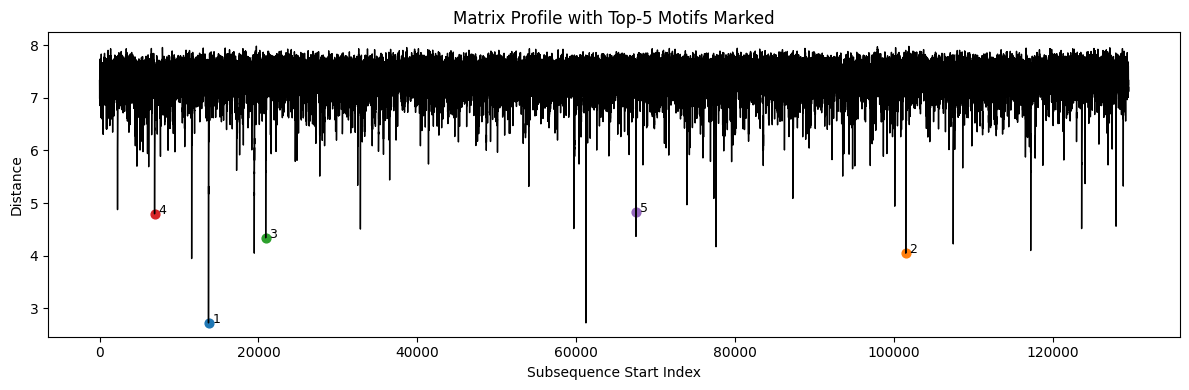

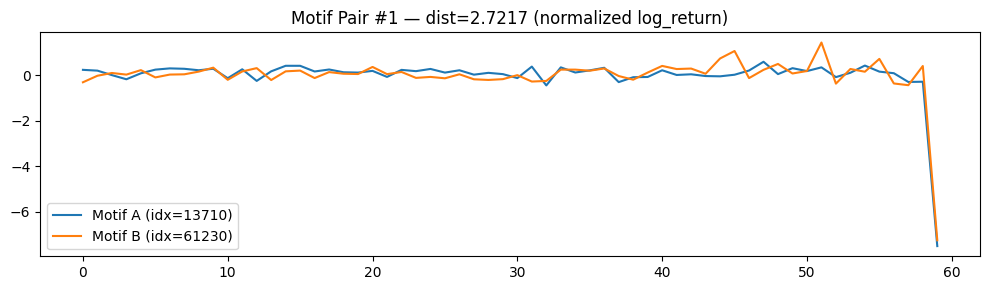

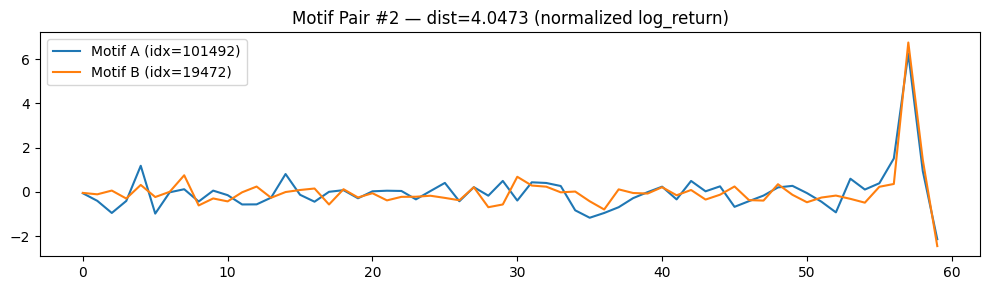

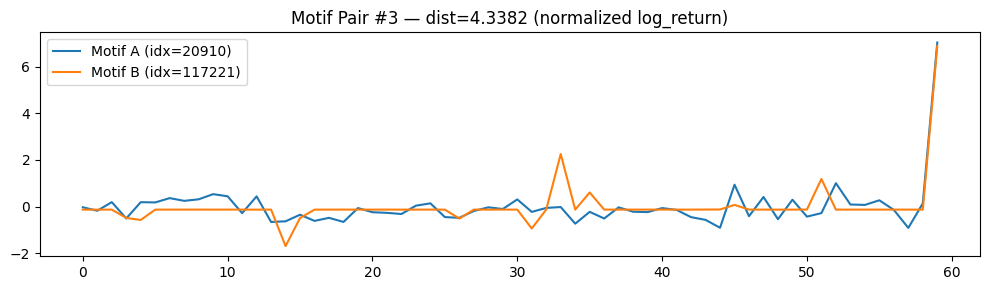

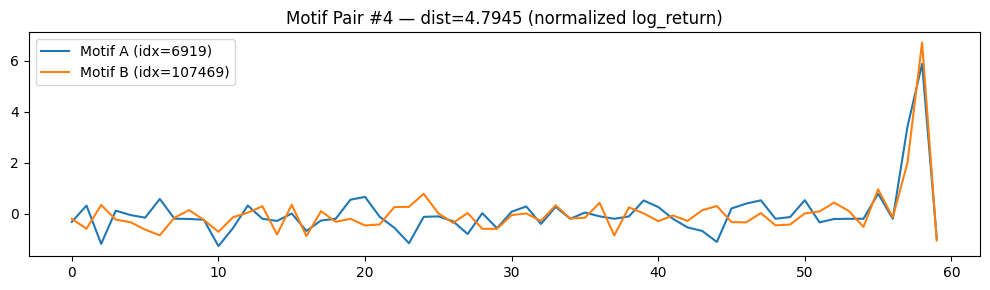

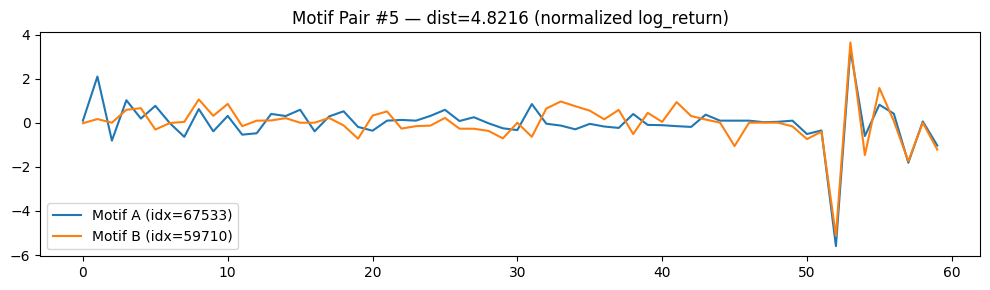

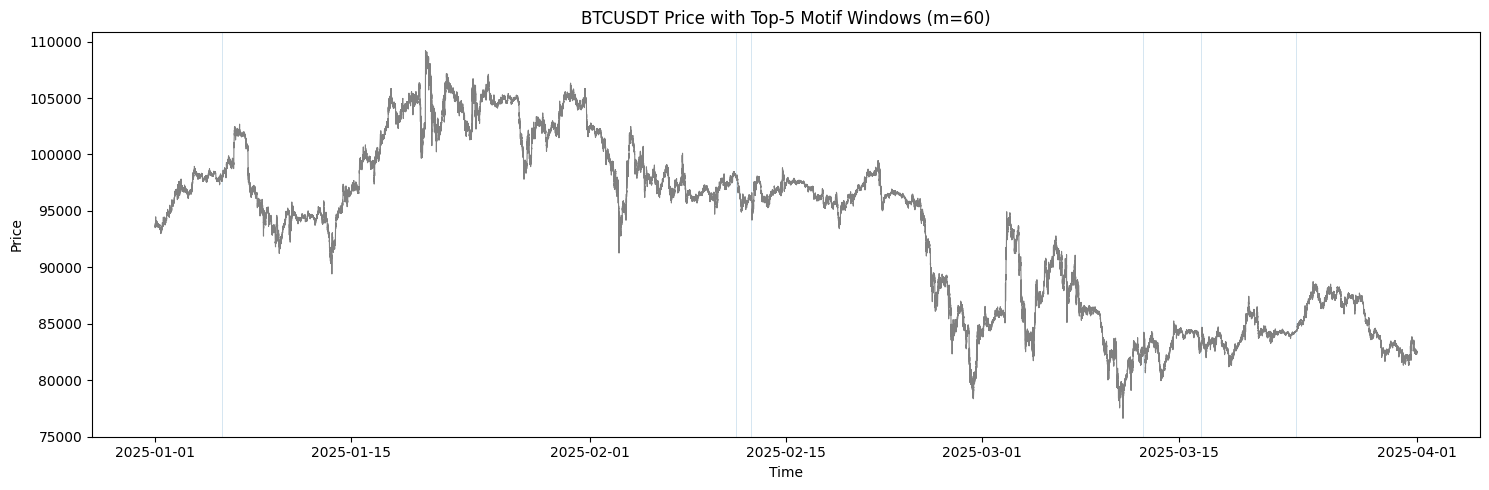

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

K = 5

# -----------------------------
# Helper: choose top-K motifs with non-overlap
# -----------------------------
def select_topk_motifs(profile, mp, m, k=5, exclusion_factor=1.0):
    """
    Select top-k motif pairs by smallest matrix profile distance,
    enforcing non-overlap around both motif and its neighbor.

    exclusion_factor=1.0 means exclude +/- m indices around chosen subsequence.
    """
    prof = np.array(profile, dtype=float).copy()
    order = np.argsort(prof)

    chosen = []
    excluded = np.zeros_like(prof, dtype=bool)
    radius = int(np.ceil(exclusion_factor * m))

    def exclude_range(i):
        lo = max(0, i - radius)
        hi = min(len(excluded), i + radius)
        excluded[lo:hi] = True

    for idx in order:
        if np.isnan(prof[idx]) or np.isinf(prof[idx]):
            continue
        if excluded[idx]:
            continue

        nn = int(mp[idx, 1])
        if nn < 0:
            continue
        if excluded[nn]:
            continue

        chosen.append((int(idx), int(nn), float(prof[idx])))

        # exclude around both subsequences
        exclude_range(idx)
        exclude_range(nn)

        if len(chosen) >= k:
            break

    return chosen

top_motifs = select_topk_motifs(profile, mp, m, k=K, exclusion_factor=1.0)

if not top_motifs:
    raise RuntimeError("No motifs selected (unexpected).")

# -----------------------------
# Summarize in markdown
# -----------------------------
lines = []
for j, (i, nn, dist) in enumerate(top_motifs, start=1):
    t_i = df.iloc[i]["open_time"]
    t_nn = df.iloc[nn]["open_time"]
    r_i = df.iloc[i]["vol_regime"]
    r_nn = df.iloc[nn]["vol_regime"]
    lines.append(
        f"{j}. **dist={dist:.4f}** | A: {t_i} ({r_i}) | B: {t_nn} ({r_nn}) | idxA={i}, idxB={nn}"
    )

display(Markdown(
f"""
# 🧩 Top {K} Motif Pairs (non-overlapping)

Window length: **m={m} minutes**  
Regime thresholds: Low < **{low_thresh:.6f}**, High > **{high_thresh:.6f}**

**Selected motifs:**
""" + "\n".join([f"- {x}" for x in lines])
))

# -----------------------------
# Visual 1: Matrix Profile + markers for top-K motifs
# -----------------------------
plt.figure(figsize=(12,4))
plt.plot(profile, color="black", linewidth=1)
for j, (i, nn, dist) in enumerate(top_motifs, start=1):
    plt.scatter(i, profile[i], s=40)
    plt.text(i, profile[i], f" {j}", fontsize=9)
plt.title(f"Matrix Profile with Top-{K} Motifs Marked")
plt.xlabel("Subsequence Start Index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# -----------------------------
# Visual 2: Normalized overlays for each motif pair (one plot per pair)
# -----------------------------
def z_norm(x):
    x = np.asarray(x, dtype=float)
    s = np.std(x)
    if s == 0:
        return x * 0.0
    return (x - np.mean(x)) / s

for j, (i, nn, dist) in enumerate(top_motifs, start=1):
    a = series[i:i+m]
    b = series[nn:nn+m]
    plt.figure(figsize=(10,3))
    plt.plot(z_norm(a), label=f"Motif A (idx={i})")
    plt.plot(z_norm(b), label=f"Motif B (idx={nn})")
    plt.title(f"Motif Pair #{j} — dist={dist:.4f} (normalized log_return)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# -----------------------------
# Visual 3: Price chart with shaded motif windows (Top-K)
# -----------------------------
plt.figure(figsize=(15,5))
plt.plot(df["open_time"], df["close"], color="gray", linewidth=0.8)

for j, (i, nn, dist) in enumerate(top_motifs, start=1):
    # shade A
    plt.axvspan(df.iloc[i]["open_time"], df.iloc[i+m]["open_time"], alpha=0.18, label=f"Motif {j}A" if j==1 else None)
    # shade B
    plt.axvspan(df.iloc[nn]["open_time"], df.iloc[nn+m]["open_time"], alpha=0.18, label=f"Motif {j}B" if j==1 else None)

plt.title(f"BTCUSDT Price with Top-{K} Motif Windows (m={m})")
plt.xlabel("Time")
plt.ylabel("Price")
plt.tight_layout()
plt.show()



# 🧩 Top 5 Motif Pairs (non-overlapping)

Window length: **m=60 minutes**  
Regime thresholds: Low < **0.000411**, High > **0.000670**

**Selected motifs:**
- 1. **dist=2.7217** | A: 2025-01-10 12:30:00+00:00 (Normal) | B: 2025-02-12 12:30:00+00:00 (Low Vol) | idxA=13710, idxB=61230
- 2. **dist=4.0473** | A: 2025-03-12 11:32:00+00:00 (Normal) | B: 2025-01-14 12:32:00+00:00 (Normal) | idxA=101492, idxB=19472
- 3. **dist=4.3382** | A: 2025-01-15 12:30:00+00:00 (Normal) | B: 2025-03-23 09:41:00+00:00 (Low Vol) | idxA=20910, idxB=117221
- 4. **dist=4.7945** | A: 2025-01-05 19:19:00+00:00 (Low Vol) | B: 2025-03-16 15:09:00+00:00 (High Vol) | idxA=6919, idxB=107469
- 5. **dist=4.8216** | A: 2025-02-16 21:33:00+00:00 (Low Vol) | B: 2025-02-11 11:10:00+00:00 (Low Vol) | idxA=67533, idxB=59710

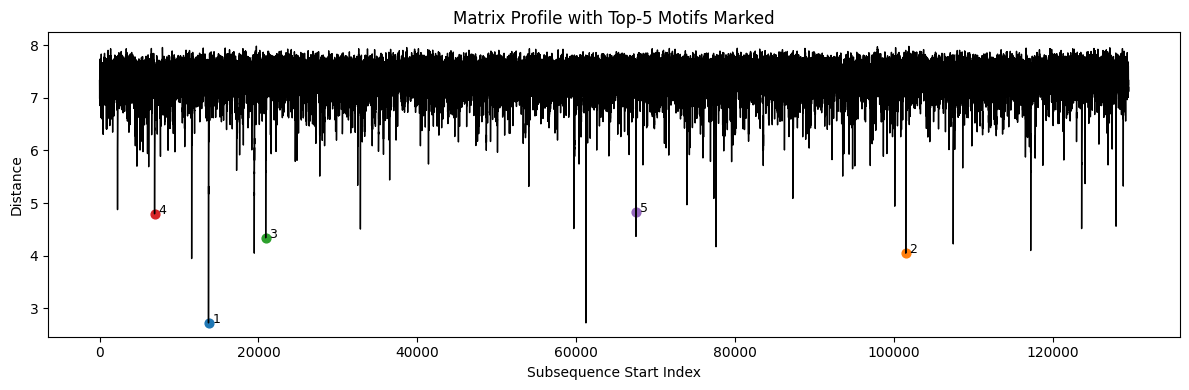

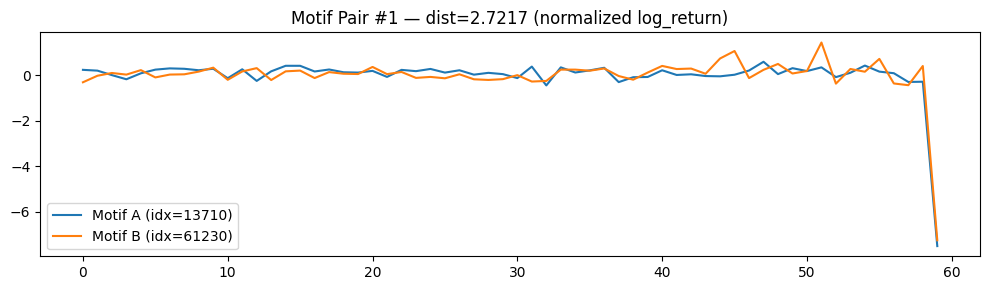

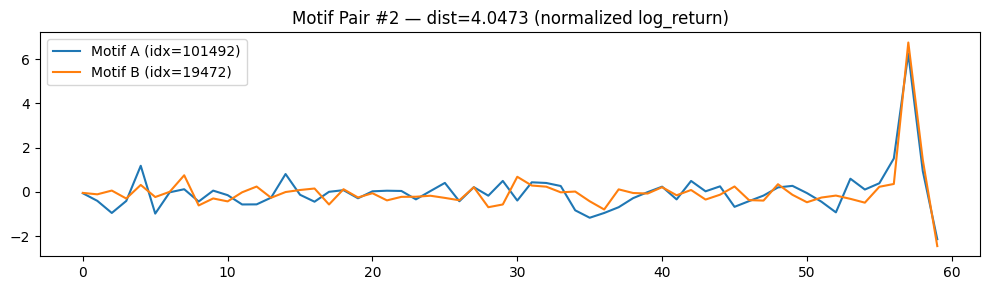

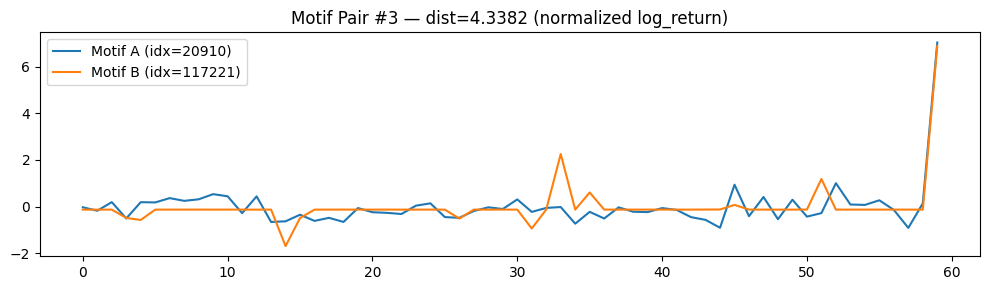

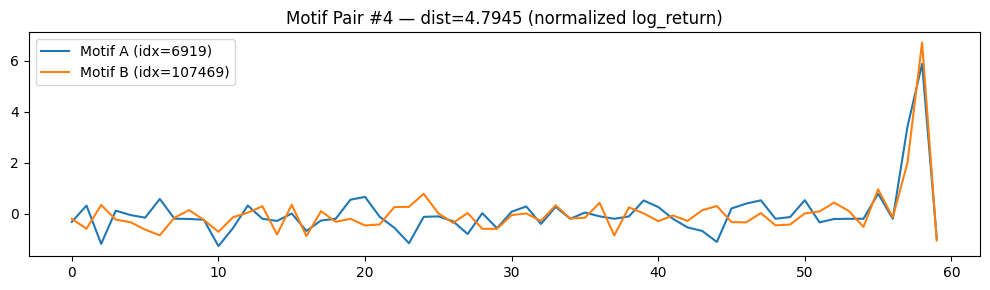

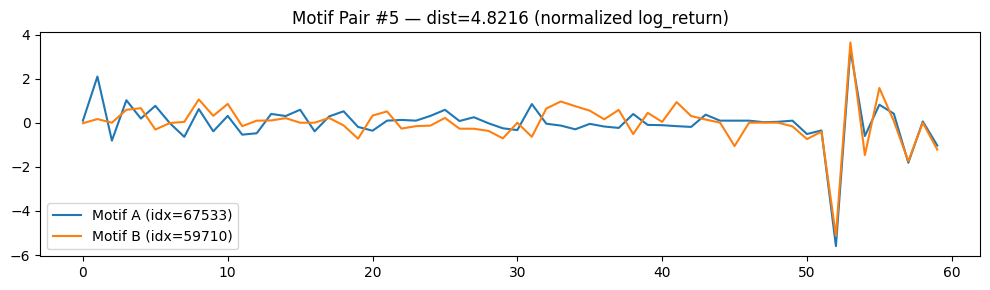

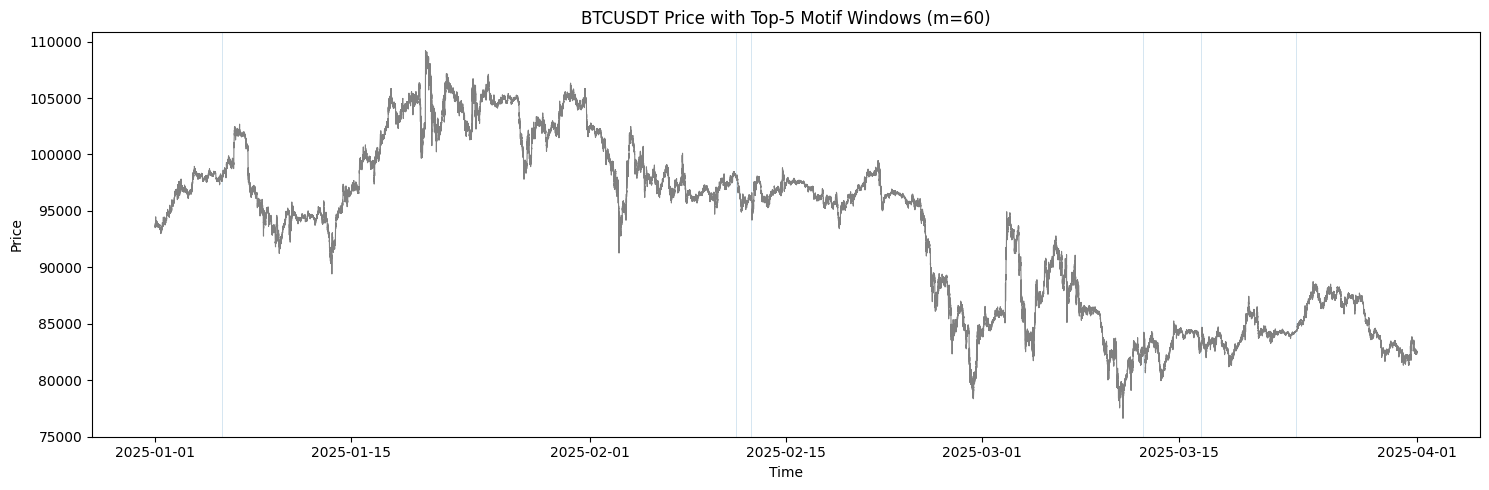

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

K = 5

# -----------------------------
# Helper: choose top-K motifs with non-overlap
# -----------------------------
def select_topk_motifs(profile, mp, m, k=5, exclusion_factor=1.0):
    """
    Select top-k motif pairs by smallest matrix profile distance,
    enforcing non-overlap around both motif and its neighbor.

    exclusion_factor=1.0 means exclude +/- m indices around chosen subsequence.
    """
    prof = np.array(profile, dtype=float).copy()
    order = np.argsort(prof)

    chosen = []
    excluded = np.zeros_like(prof, dtype=bool)
    radius = int(np.ceil(exclusion_factor * m))

    def exclude_range(i):
        lo = max(0, i - radius)
        hi = min(len(excluded), i + radius)
        excluded[lo:hi] = True

    for idx in order:
        if np.isnan(prof[idx]) or np.isinf(prof[idx]):
            continue
        if excluded[idx]:
            continue

        nn = int(mp[idx, 1])
        if nn < 0:
            continue
        if excluded[nn]:
            continue

        chosen.append((int(idx), int(nn), float(prof[idx])))

        # exclude around both subsequences
        exclude_range(idx)
        exclude_range(nn)

        if len(chosen) >= k:
            break

    return chosen

top_motifs = select_topk_motifs(profile, mp, m, k=K, exclusion_factor=1.0)

if not top_motifs:
    raise RuntimeError("No motifs selected (unexpected).")

# -----------------------------
# Summarize in markdown
# -----------------------------
lines = []
for j, (i, nn, dist) in enumerate(top_motifs, start=1):
    t_i = df.iloc[i]["open_time"]
    t_nn = df.iloc[nn]["open_time"]
    r_i = df.iloc[i]["vol_regime"]
    r_nn = df.iloc[nn]["vol_regime"]
    lines.append(
        f"{j}. **dist={dist:.4f}** | A: {t_i} ({r_i}) | B: {t_nn} ({r_nn}) | idxA={i}, idxB={nn}"
    )

display(Markdown(
f"""
# 🧩 Top {K} Motif Pairs (non-overlapping)

Window length: **m={m} minutes**  
Regime thresholds: Low < **{low_thresh:.6f}**, High > **{high_thresh:.6f}**

**Selected motifs:**
""" + "\n".join([f"- {x}" for x in lines])
))

# -----------------------------
# Visual 1: Matrix Profile + markers for top-K motifs
# -----------------------------
plt.figure(figsize=(12,4))
plt.plot(profile, color="black", linewidth=1)
for j, (i, nn, dist) in enumerate(top_motifs, start=1):
    plt.scatter(i, profile[i], s=40)
    plt.text(i, profile[i], f" {j}", fontsize=9)
plt.title(f"Matrix Profile with Top-{K} Motifs Marked")
plt.xlabel("Subsequence Start Index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# -----------------------------
# Visual 2: Normalized overlays for each motif pair (one plot per pair)
# -----------------------------
def z_norm(x):
    x = np.asarray(x, dtype=float)
    s = np.std(x)
    if s == 0:
        return x * 0.0
    return (x - np.mean(x)) / s

for j, (i, nn, dist) in enumerate(top_motifs, start=1):
    a = series[i:i+m]
    b = series[nn:nn+m]
    plt.figure(figsize=(10,3))
    plt.plot(z_norm(a), label=f"Motif A (idx={i})")
    plt.plot(z_norm(b), label=f"Motif B (idx={nn})")
    plt.title(f"Motif Pair #{j} — dist={dist:.4f} (normalized log_return)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# -----------------------------
# Visual 3: Price chart with shaded motif windows (Top-K)
# -----------------------------
plt.figure(figsize=(15,5))
plt.plot(df["open_time"], df["close"], color="gray", linewidth=0.8)

for j, (i, nn, dist) in enumerate(top_motifs, start=1):
    # shade A
    plt.axvspan(df.iloc[i]["open_time"], df.iloc[i+m]["open_time"], alpha=0.18, label=f"Motif {j}A" if j==1 else None)
    # shade B
    plt.axvspan(df.iloc[nn]["open_time"], df.iloc[nn+m]["open_time"], alpha=0.18, label=f"Motif {j}B" if j==1 else None)

plt.title(f"BTCUSDT Price with Top-{K} Motif Windows (m={m})")
plt.xlabel("Time")
plt.ylabel("Price")
plt.tight_layout()
plt.show()
